### Creating replay for fixation condition in Passive Active Vision project

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy import interpolate

1. Smooth the data with a Savitzky-Golay filter with polynomial order 2 and window size of 13ms.

In [2]:
def sav_gol(df, **kwargs):
    """
    Smooth the data with a Savitzky-Golay filter
    :param df: data frame with columns x and y to be filtered 
    :param \**kwargs: arguments for the signal.savgol_filter 
    :return: modified copy df with columns x and y filtered
    """
    savgol_x = signal.savgol_filter(df.x,**kwargs)
    savgol_y = signal.savgol_filter(df.y,**kwargs)
    
    pd.options.mode.chained_assignment = None  # default='warn'
    df_copy = df.copy()
    df_copy.loc[:,"x"] = savgol_x
    df_copy.loc[:,"y"] = savgol_y
    return df_copy
    

In [3]:
# list of column names which needs to be string
lst_str_cols = ['identifier']
# use dictionary comprehension to make dict of dtypes
dict_dtypes = {x : 'str'  for x in lst_str_cols}
# use dict on dtypes
df = pd.read_csv("../separate_participant_data/Raw_Data/raw_subj_1.dat", sep = ",", dtype=dict_dtypes)
df_im = df[df.imageno==50]

In [4]:
kwargs = {"window_length":13,"polyorder":2,"mode":"nearest"}
df_filtered = sav_gol(df_im, **kwargs)

In [5]:
df_filtered

,identifier,time,x,y,pupil,imageno,invalid,filtertype,is_saccade,filterregion,targetpresent,expectedlocation
0,00100101,4239225,18.935151,13.793290,6802.0,50,0,1,0,2,0,0
1,00100101,4239226,18.934970,13.788399,6802.0,50,0,1,0,2,0,0
2,00100101,4239227,18.932512,13.782448,6804.0,50,0,1,0,2,0,0
3,00100101,4239228,18.928864,13.776006,6804.0,50,0,1,0,2,0,0
4,00100101,4239229,18.923404,13.768502,6804.0,50,0,1,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5823,00100121,4245048,23.672522,15.226147,10293.0,50,1,1,0,2,0,0
5824,00100121,4245049,23.636299,15.199678,10268.0,50,1,1,0,2,0,0
5825,00100121,4245050,23.605586,15.174062,10268.0,50,1,1,0,2,0,0
5826,00100121,4245051,23.583231,15.151603,10262.0,50,1,1,0,2,0,0


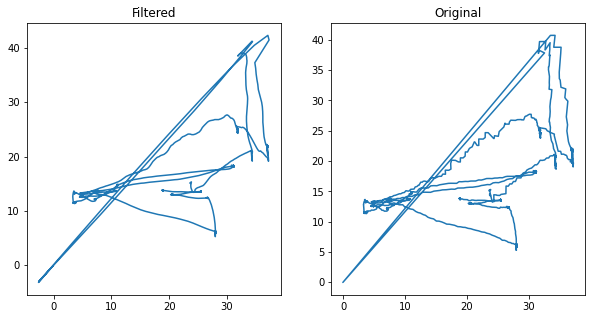

In [6]:
#Comparison between filtered and non-filtered:
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(10,5))
ax0.plot(df_filtered.x, df_filtered.y)
ax0.set_title("Filtered")
ax1.plot(df_im.x, df_im.y)
ax1.set_title("Original")
plt.show()

2. Upsample the data (by linear interpolation) to match our projector frequency of 1440Hz
Upsampling is now done with scipy.interpolate.interp1d, that behaves better than pandas.resample.interpolate

In [7]:
def upsampling(df):
    """
    
    """
    df_time = df.set_index(pd.to_timedelta(df.index, unit='ms')) #put the index as time in ms
    
    #Resample two data frames, one interpolating the x and y with scipy.interpolate and the other doing ffil() on pandas.resample, 
    #i.e, forward fill method that uses the last known value to replace the NaN.
   
    time_original = df_time.index.to_numpy(dtype=float)*1e-9 #now we have an array in seconds
    
    x_original = df_time.x.to_numpy(dtype=float)
    y_original = df_time.y.to_numpy(dtype=float)
    
    df_final = df_time.drop(columns=["x","y"])
    df_final = df_final.resample('0.694444L').ffill()
    
    time_resampled = df_final.index.to_numpy(dtype=float)*1e-9
    
    f_interpol_x = interpolate.interp1d(time_original,x_original)
    f_interpol_y = interpolate.interp1d(time_original,y_original)
    
    x_resampled = f_interpol_x(time_resampled)
    y_resampled = f_interpol_y(time_resampled)
    
    df_final.insert(2, "x",x_resampled)
    df_final.insert(3, "y",y_resampled)
    
    return df_final
    

In [8]:
df_upsampled = upsampling(df_filtered)

In [9]:
df_upsampled

,identifier,time,x,y,pupil,imageno,invalid,filtertype,is_saccade,filterregion,targetpresent,expectedlocation
00:00:00,00100101,4239225,18.935151,13.793290,6802.0,50,0,1,0,2,0,0
00:00:00.000694,00100101,4239225,18.935025,13.789894,6802.0,50,0,1,0,2,0,0
00:00:00.001388,00100101,4239226,18.934014,13.786085,6802.0,50,0,1,0,2,0,0
00:00:00.002083,00100101,4239227,18.932208,13.781911,6804.0,50,0,1,0,2,0,0
00:00:00.002777,00100101,4239227,18.929674,13.777437,6804.0,50,0,1,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
00:00:05.823607,00100121,4245048,23.650521,15.210070,10293.0,50,1,1,0,2,0,0
00:00:05.824301,00100121,4245049,23.627029,15.191946,10268.0,50,1,1,0,2,0,0
00:00:05.824996,00100121,4245049,23.605701,15.174158,10268.0,50,1,1,0,2,0,0
00:00:05.825690,00100121,4245050,23.590145,15.158550,10268.0,50,1,1,0,2,0,0


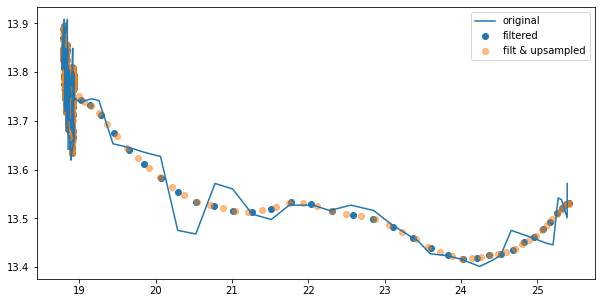

In [10]:
plt.figure(figsize=(10,5))
plt.scatter(df_filtered[(df_filtered.identifier=="00100101")].x,
         df_filtered[(df_filtered.identifier=="00100101")].y, label = "filtered")
plt.scatter(df_upsampled[(df_upsampled.identifier=="00100101")].x,
         df_upsampled[(df_upsampled.identifier=="00100101")].y, 
            label="filt & upsampled", alpha=0.5)
plt.plot(df_im[(df_im.identifier=="00100101")].x,
         df_im[(df_im.identifier=="00100101")].y, label = "original")
plt.legend()

NOW DO THIS FOR EVERY IMAGE AND EVERY PARTICIPANT!

3. Get the point to point velocity, find the peak velocity for a saccade and estimate the velocity profile. 

Apply a moving-average smoother with a span of 5 on your data before you compute sample-to-sample velocity
This is equivalent to performing a convolution with a kernel of width 5 and 1/5 in every entry. -> np.convolve(x, np.ones(5)/5, mode='valid')


In [11]:
#identifier is 3 digits of subjet number + 3 digits trial number + 2 digits fixation/saccade number.

In [12]:
for count,idt  in enumerate(np.unique(df_upsampled.identifier)): #identifier tells saccade number
    print(idt, count)

00100101 0
00100102 1
00100103 2
00100104 3
00100105 4
00100106 5
00100107 6
00100108 7
00100109 8
00100110 9
00100111 10
00100112 11
00100113 12
00100114 13
00100115 14
00100116 15
00100117 16
00100118 17
00100119 18
00100120 19
00100121 20


In [13]:
#calculate euclidian distance between two sets of points and divide by the time step between them
#euclidian distance: dist = numpy.linalg.norm(a-b)
dt = 0.694444 #ms
#velocity is gonna be in dva/ms

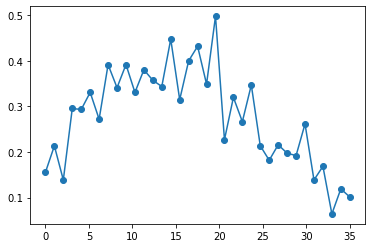

In [14]:
#POINT TO POINT VELOCITY IN THE ORIGINAL DATA
#have this inside the loop with identifiers 
temp_sacc_im = df_im[(df_im.identifier=="00100101") & (df_im.is_saccade == 1)]
if len(temp_sacc_im) != 0:
    #get point to point velocity
    diff_xy_im = np.diff(np.asarray(temp_sacc_im[["x","y"]]),axis=0) #get the diff between consecutives x and y points
    dist_xy_im = np.sqrt((diff_xy_im**2).sum(axis=1)) #get the distances between consecutives (x,y) pairs
t_im = np.linspace(0,len(dist_xy_im),len(dist_xy_im))
plt.scatter(t_im,dist_xy_im/dt)
plt.plot(t_im,dist_xy_im/dt)


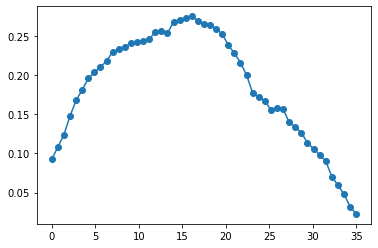

In [15]:
#POINT TO POINT VELOCITY FOR THE UPSAMPLED DATA
#have this inside the loop with identifiers 
temp_sacc_up = df_upsampled[(df_upsampled.identifier=="00100101") & (df_upsampled.is_saccade == 1)]
if len(temp_sacc_up) != 0:
    #get point to point velocity
    diff_xy_up = np.diff(np.asarray(temp_sacc_up[["x","y"]]),axis=0) #get the diff between consecutives x and y points
    dist_xy_up = np.sqrt((diff_xy_up**2).sum(axis=1)) #get the distances between consecutives (x,y) pairs
t_up = np.linspace(0,len(dist_xy_im),len(dist_xy_up))
plt.scatter(t_up,dist_xy_up/dt)
plt.plot(t_up,dist_xy_up/dt)

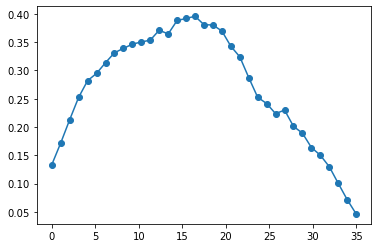

In [16]:
#POINT TO POINT VELOCITY FOR THE FILTERED DATA
#have this inside the loop with identifiers 
temp_sacc_fil = df_filtered[(df_filtered.identifier=="00100101") & (df_filtered.is_saccade == 1)]
if len(temp_sacc_fil) != 0:
    #get point to point velocity
    diff_xy_fil = np.diff(np.asarray(temp_sacc_fil[["x","y"]]),axis=0) #get the diff between consecutives x and y points
    dist_xy_fil = np.sqrt((diff_xy_fil**2).sum(axis=1)) #get the distances between consecutives (x,y) pairs
t_fil = np.linspace(0,len(dist_xy_fil),len(dist_xy_fil))
plt.scatter(t_fil,dist_xy_fil/dt)
plt.plot(t_fil,dist_xy_fil/dt)


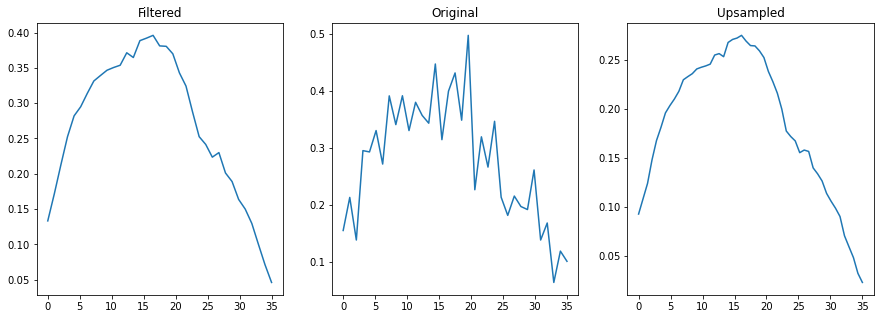

In [17]:
fig, (ax0, ax1,ax2) = plt.subplots(1,3,figsize=(15,5))
ax0.plot(t_fil,dist_xy_fil/dt, label = "filtered")
ax0.set_title("Filtered")
ax1.plot(t_im,dist_xy_im/dt, label = "original")
ax1.set_title("Original")
ax2.plot(t_up,dist_xy_up/dt, label = "up")
ax2.set_title("Upsampled")
plt.show()

In [21]:
vel_xy_convolved_filtered = np.convolve((dist_xy_fil/1e-3), np.ones(5)/5, mode='valid')
vel_xy_convolved_upsampled = np.convolve((dist_xy_up/(dt*1e-3)), np.ones(5)/5, mode='valid')


In [24]:
dist_xy_fil.shape

(35,)

In [25]:
vel_xy_convolved_filtered.shape

(31,)

ValueError: x and y must have same first dimension, but have shapes (35,) and (31,)

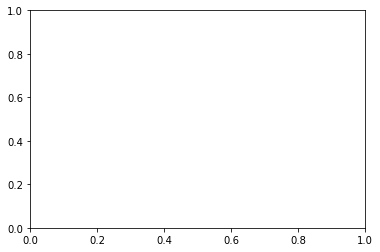

In [22]:
#put velocity in dva/second
plt.plot(t_fil,vel_xy_convolved_filtered, label = "filtered")
plt.plot(t_up,vel_xy_convolved_upsampled, label = "upsampled")
plt.legend()
plt.show()